In [156]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass

In [157]:
# Environment

@dataclass
class QSettings():
    epsilon: float
    discount: float
    learning_rate: float
        

class Environment():
    def __init__(self, nrows: int, ncols: int, starting_location: tuple, end_location: tuple, nobstacles: int, qsettings: QSettings):
        self.nrows = nrows
        self.ncols = ncols
        self.mapsize = (nrows, ncols)
        self.starting_location = starting_location
        self.default_location = self.starting_location
        self.startingrow, self.startingcol = self.starting_location
        self.end_location = end_location
        self.endrow, self.endcol = self.end_location
        self.nobstacles = nobstacles
        self.qsettings = qsettings
        self.actions = ['up', 'down', 'left', 'right']
        
        self.currentrow, self.currentcol = self.starting_location
        
        self.obstacles = []
        self.rewards = np.full((self.nrows, self.ncols), -1.)
        self.qtable = np.zeros((self.nrows, self.ncols, len(self.actions))) # nrows x ncols x nactions
        
        self.basereward = -1
        self.enemyreward = -300
        self.endreward = 300
        
        self.__build_obstacles__()
        self.__build_rewards__()
        
        self.initialized = True
        self.trained = False
        self.ran = False
        
    def __build_obstacles__(self):
        if len(self.obstacles) <= 0:
            while len(self.obstacles) < self.nobstacles:
                randrow = np.random.randint(self.nrows)
                randcol = np.random.randint(self.ncols)
                if (randrow, randcol) not in self.obstacles:
                    if (randrow,randcol) != self.starting_location and (randrow,randcol) != self.end_location:
                        self.obstacles.append((randrow, randcol))
                        
    def __build_rewards__(self):
        for obstacle in self.obstacles:
            ob_row, ob_col = obstacle
            self.rewards[ob_row][ob_col] = self.enemyreward
        self.rewards[self.end_location[0]][self.end_location[1]] = self.endreward
    
    
    def is_enemy(self, row, col):
        return self.rewards[row][col] == self.enemyreward
    def is_end(self, row, col):
        return self.rewards[row][col] == self.endreward
    
    def get_next_action(self, current_row_index, current_column_index):
        """Next action is decided based on the epsilon-greedy algorithm.
        If a random number is smaller than a value epsilon, the max value from the queue table is selected.
        Otherwise, if the random number is larger, pick a random action
        """
        if np.random.random() < self.qsettings.epsilon:
            return np.argmax(self.qtable[current_row_index, current_column_index])
        else: #choose a random action
            return np.random.randint(len(self.actions))
        
    def get_next_location(self,current_row_index, current_column_index, action_index: int):
        new_row_index = current_row_index
        new_column_index = current_column_index
        if self.actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1
        elif self.actions[action_index] == 'right' and current_column_index < self.ncols - 1:
            new_column_index += 1
        elif self.actions[action_index] == 'down' and current_row_index < self.nrows - 1:
            new_row_index += 1
        elif self.actions[action_index] == 'left' and current_column_index > 0:
            new_column_index -= 1
        return new_row_index, new_column_index
    
    def showmap(self):
        print(len(self.obstacles))
        if len(self.obstacles) > 0:
            fig, ax = plt.subplots(figsize=(9,9))
            ax.set_title("Reward map")
            ax.set_xlabel("col")
            ax.set_ylabel("row")
            rewardmap = self.rewards
            rewardmap[self.startingrow][self.startingcol] = -50
            ax.imshow(rewardmap)
            plt.show()
    
    def showpath(self, path: list):
        if self.run and len(path) > 0:
            plt.clf()
            newmap = self.rewards
            newmap[path[0][0]][path[0][1]] = -50
            print("===> ",path)
            for pos in path:
                r, c = pos
                newmap[r][c] = 100
            fig2, ax2 = plt.subplots(figsize=(9,9))
            ax2.set_title("Reward map")
            ax2.set_xlabel("col")
            ax2.set_ylabel("row")
            ax2.imshow(newmap)
        plt.show()
    
    def reset(self):
        self.currentrow = self.startingrow
        self.currentcol = self.startingcol
            
    def train(self, epochs: int, verbose: bool = False):
        for epoch in range(epochs):
            self.reset()
            row, col = self.starting_location
            while (not self.is_end(self.currentrow, self.currentcol)) and (not self.is_enemy(self.currentrow, self.currentcol)):
                actionindex = self.get_next_action(self.currentrow, self.currentcol)
                oldrow, oldcol = self.currentrow, self.currentcol
                self.currentrow, self.currentcol = self.get_next_location(self.currentrow, self.currentcol, actionindex)
                
                reward = self.rewards[self.currentrow][self.currentcol]
                old_q = self.qtable[oldrow, oldcol, actionindex]
                temporaldiff = reward + (self.qsettings.discount * np.max(self.qtable[self.currentrow, self.currentcol])) - old_q
                new_q = old_q + (self.qsettings.learning_rate * temporaldiff)
                self.qtable[oldrow, oldcol, actionindex] = new_q
        self.trained = True
        print("Training complete")
        
    
    def run(self, maxiterations: int = 10000, startpos: tuple = None, verbose: bool = False):
        if startpos is not None:
            self.starting_location = startpos
            self.startingrow = startpos[0]
            self.startingcol = startpos[1]
        if self.is_enemy(self.startingrow, self.startingcol) or self.is_end(self.startingrow, self.startingcol):
            return []
        else:
            self.reset()
            shortestpath = []
            shortestpath.append(self.starting_location)
            #i: int = 0
            print("==> ",self.currentrow, self.currentcol)
            while (not self.is_end(self.currentrow, self.currentcol)) and (not self.is_enemy(self.currentrow, self.currentcol)):
                actionindex = self.get_next_action(self.currentrow, self.currentcol)
                self.currentrow, self.currentcol = self.get_next_location(self.currentrow, self.currentcol, actionindex)
                shortestpath.append((self.currentrow, self.currentcol))
                #i+=1
                #if (i >= maxiterations):
                #    print(f"Reached maximum iterations {maxiterations}. Current position: ({self.currentrow},{self.currentcol})")
                #    return []
            self.ran = True
            return shortestpath
    
    
    
            
        

In [158]:
e = Environment(
    30,30,
    (1,1),
    (28,28),
    100,
    QSettings(epsilon=0.9, discount=0.95, learning_rate=0.9)
)

100


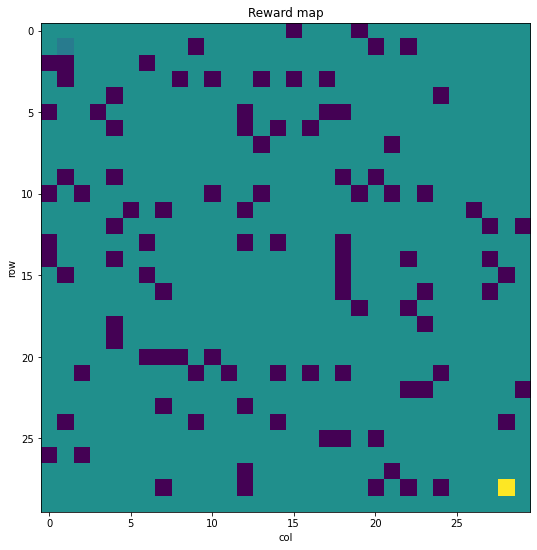

In [159]:
e.showmap()

In [160]:
e.train(50000)

Training complete


In [161]:
shortestpath = e.run()

==>  1 1


===>  [(1, 1), (1, 2), (2, 2), (3, 2), (4, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (8, 2), (9, 2), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (16, 3), (17, 3), (18, 3), (19, 3), (20, 3), (21, 3), (22, 3), (21, 3), (22, 3), (23, 3), (24, 3), (25, 3), (26, 3), (26, 4), (26, 5), (26, 6), (27, 6), (27, 7), (27, 8), (27, 9), (27, 8), (27, 9), (27, 10), (26, 10), (26, 11), (26, 12), (25, 12), (26, 12), (26, 13), (26, 14), (26, 15), (26, 16), (26, 17), (26, 18), (26, 19), (26, 20), (26, 21), (26, 22), (26, 23), (27, 23), (27, 24), (27, 25), (28, 25), (29, 25), (28, 25), (28, 26), (28, 27), (28, 28)]


<Figure size 432x288 with 0 Axes>

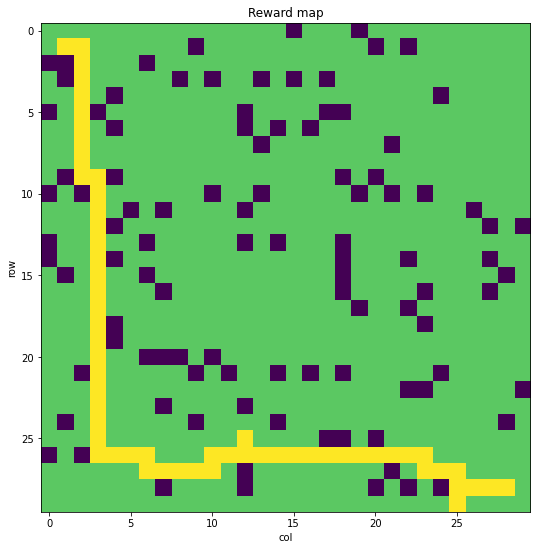

In [162]:
e.showpath(shortestpath)

In [163]:
print(shortestpath)

[(1, 1), (1, 2), (2, 2), (3, 2), (4, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (8, 2), (9, 2), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (16, 3), (17, 3), (18, 3), (19, 3), (20, 3), (21, 3), (22, 3), (21, 3), (22, 3), (23, 3), (24, 3), (25, 3), (26, 3), (26, 4), (26, 5), (26, 6), (27, 6), (27, 7), (27, 8), (27, 9), (27, 8), (27, 9), (27, 10), (26, 10), (26, 11), (26, 12), (25, 12), (26, 12), (26, 13), (26, 14), (26, 15), (26, 16), (26, 17), (26, 18), (26, 19), (26, 20), (26, 21), (26, 22), (26, 23), (27, 23), (27, 24), (27, 25), (28, 25), (29, 25), (28, 25), (28, 26), (28, 27), (28, 28)]


==>  9 22


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<Figure size 432x288 with 0 Axes>

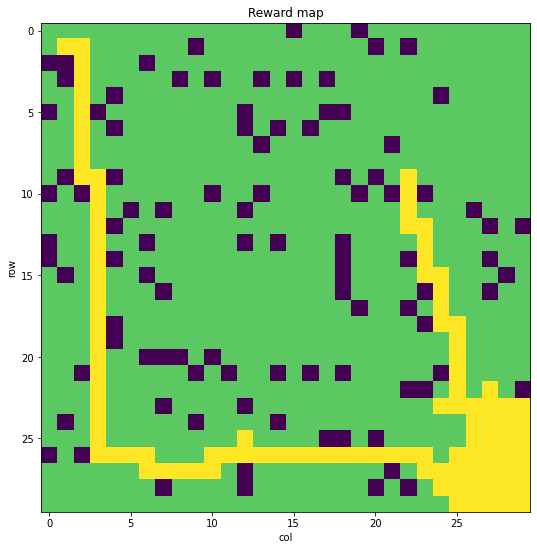

In [165]:
r2 = e.run(startpos=(9,22))
e.showpath(r2)